In [ ]:
import os
import torch

# 1. 确保在正确的目录
if not os.path.exists("LPRNet_Pytorch"):
    !git clone https://github.com/sirius-ai/LPRNet_Pytorch.git
%cd /content/LPRNet_Pytorch

# 2. 确保权重已下载
if not os.path.exists("lprnet_standard.pth"):
    !wget https://github.com/sirius-ai/LPRNet_Pytorch/raw/master/weights/Final_LPRNet_model.pth -O lprnet_standard.pth

# 3. 编写修复后的导出脚本
export_script = """
import torch
from model.LPRNet import LPRNet

# 【核心修复】补全了缺失的参数
# lpr_max_len=8: 车牌最大长度
# phase=False: 测试模式
# class_num=68: 类别数
device = torch.device('cpu')
lprnet = LPRNet(lpr_max_len=8, phase=False, class_num=68, dropout_rate=0.5)

# 加载权重
print("加载模型中...")
lprnet.load_state_dict(torch.load("lprnet_standard.pth", map_location=device))
lprnet.to(device)
lprnet.eval()

# 导出 ONNX
# 输入尺寸：Batch=1, Channel=3, Height=24, Width=94
dummy_input = torch.randn(1, 3, 24, 94).to(device)
output_file = "lprnet_standard.onnx"

torch.onnx.export(lprnet,
                  dummy_input,
                  output_file,
                  input_names=['input'],
                  output_names=['output'],
                  dynamic_axes={'input': {0: 'batch'}, 'output': {0: 'batch'}})

print(f"\\n✅ 成功！ONNX 模型已生成: {output_file}")
"""

# 将脚本写入文件
with open("run_export_fixed.py", "w") as f:
    f.write(export_script)

# 4. 运行导出
print("开始导出...")
!python run_export_fixed.py

Cloning into 'LPRNet_Pytorch'...
remote: Enumerating objects: 1071, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 1071 (delta 25), reused 22 (delta 22), pack-reused 1037 (from 1)
Receiving objects: 100% (1071/1071), 20.04 MiB | 24.78 MiB/s, done.
Resolving deltas: 100% (35/35), done.
/content/LPRNet_Pytorch
--2025-12-18 09:09:17--  https://github.com/sirius-ai/LPRNet_Pytorch/raw/master/weights/Final_LPRNet_model.pth
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sirius-ai/LPRNet_Pytorch/master/weights/Final_LPRNet_model.pth [following]
--2025-12-18 09:09:18--  https://raw.githubusercontent.com/sirius-ai/LPRNet_Pytorch/master/weights/Final_LPRNet_model.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133,

In [ ]:
!pip install onnxscript

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.4/693.4 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 117.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 11.0 MB/s eta 0:00:00


In [ ]:
!python run_export_fixed.py

加载模型中...
/content/LPRNet_Pytorch/run_export_fixed.py:23: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(lprnet,
[torch.onnx] Obtain model graph for `LPRNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `LPRNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 6 of general pattern rewrite rules.

✅ 成功！ONNX 模型已生成: lprnet_standard.onnx


In [ ]:
import onnx
from onnx.external_data_helper import load_external_data_for_model
import os

# ================= 配置区域 =================
# 修改这里：你要合并的文件路径
input_path = "/content/lprnet_standard.onnx"
# input_path = "/content/yolox_plate.onnx" # 如果要合并 YOLOX 就解开这行

# 输出的新文件名
output_path = input_path.replace(".onnx", "_merged.onnx")
# ===========================================

print(f"正在读取模型: {input_path} ...")

if not os.path.exists(input_path):
    print("❌ 找不到文件！请检查路径是否正确。")
else:
    # 1. 加载模型结构
    model = onnx.load(input_path, load_external_data=False)

    # 2. 强制加载外部数据到内存 (把 .data 吃进去)
    # base_dir 指定为当前目录，它会自动找同名的 .data 文件
    load_external_data_for_model(model, base_dir=os.path.dirname(input_path))

    print("正在合并并保存...")

    # 3. 直接保存
    # 新版 onnx 库默认行为：如果模型小于 2GB，save 会自动保存为单文件
    onnx.save(model, output_path)

    # 验证一下
    if os.path.exists(output_path):
        size_mb = os.path.getsize(output_path) / 1024 / 1024
        print("------------------------------------------------")
        print("✅ 合并成功！")
        print(f"新文件: {output_path}")
        print(f"新文件大小: {size_mb:.2f} MB")
        print("------------------------------------------------")

        # 简单检查：如果新文件比原来的 .onnx 大很多（接近 .data 的大小），说明合并对了
        original_size = os.path.getsize(input_path)
        if os.path.getsize(output_path) > original_size * 2:
            print("✨ 验证通过：文件变大了，说明权重已经塞进去了！")
        else:
            print("⚠️ 警告：文件大小没怎么变，可能哪里不对。")

正在读取模型: /content/lprnet_standard.onnx ...
❌ 找不到文件！请检查路径是否正确。


In [2]:
!pip install onnxruntime onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.3 MB/s eta 0:00:00


🚀 开始加载模型...
✅ 模型加载完毕！
🎉 YOLOX 最终锁定了 1 个区域！

--- 正在分析第 1 个区域 ---
坐标: x=0, y=0, w=720, h=1160


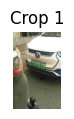

⚠️ 长度异常(6): 京宁宁宁京京
✅ 最终识别结果: 【 京宁宁宁京京 】

=== 最终效果图 ===


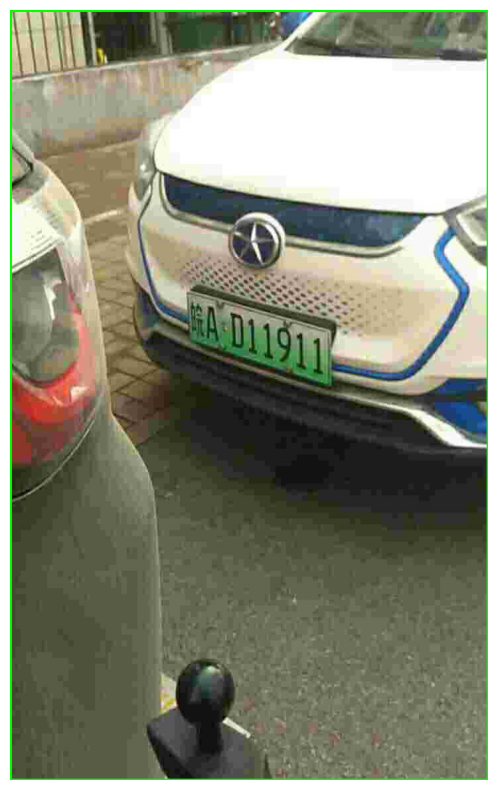

In [ ]:
import cv2
import numpy as np
import onnxruntime
import matplotlib.pyplot as plt
import os

# ================= 配置区域 =================
# 1. 模型路径 (请根据实际情况修改文件名)
yolox_path = "/content/yolox_plate_py38_op11_fixed.onnx"
lprnet_path = "/content/my_lprnet_op11.onnx"
image_path = "/content/car.jpg"
#lprnet_path = "/content/yolox_plate_merged.onnx"

# 2. 如果没有图片，自动下载一张测试图
if not os.path.exists(image_path):
    print("没有找到测试图，正在下载一张网图...")
    !wget https://github.com/Megvii-BaseDetection/YOLOX/raw/main/assets/dog.jpg -O temp.jpg # 只是个占位，最好自己上传车牌图
    # 这里建议你自己上传一张叫 test_car.jpg 的车牌图到 /content/ 目录下
    print("⚠️ 注意：我没找到车牌图，请最好手动上传一张 'test_car.jpg'！")

# 3. LPRNet 字符表 (必须和模型配套)
CHARS = [
    '京','沪','津','渝','冀','晋','蒙','辽','吉','黑',
    '苏','浙','皖','闽','赣','鲁','豫','鄂','湘','粤',
    '桂','琼','川','贵','云','藏','陕','甘','青','宁',
    '新',
    '0','1','2','3','4','5','6','7','8','9',
    'A','B','C','D','E','F','G','H','J','K',
    'L','M','N','P','Q','R','S','T','U','V',
    'W','X','Y','Z',
    '-'
]

# 2. 最简单的解码函数
def decode_lpr(preds):
    """
    preds: 应该是已经做过 np.argmax 的一维数组
    例如: [67, 12, 42, 67, 67...]
    """
    # 如果传进来的是二维的 (1, 18)，先转成一维
    if len(preds.shape) > 1:
        preds = preds[0]

    res = []
    for i in range(len(preds)):
        idx = preds[i]

        # 1. 如果是空白字符 (67)，直接跳过
        if idx == len(CHARS) - 1:
            continue

        # 2. 去重逻辑 (CTC规则)：
        # 如果当前字符和前一个字符一样，且中间没有空白，则认为是重复，跳过
        # (但这里我们简单点：只要不是空白，且和上一个存进去的不一样，就存)
        if len(res) > 0 and idx == CHARS.index(res[-1]) and preds[i-1] != len(CHARS) - 1:
            continue

        res.append(CHARS[idx])

    return "".join(res)

# ================= 工具函数 =================

def preprocess_yolox(img, input_size=(640, 640)):
    # YOLOX 预处理：Resize + Padding
    padded_img = np.ones((input_size[0], input_size[1], 3), dtype=np.uint8) * 114
    r = min(input_size[0] / img.shape[0], input_size[1] / img.shape[1])
    resized_img = cv2.resize(
        img, (int(img.shape[1] * r), int(img.shape[0] * r)), interpolation=cv2.INTER_LINEAR
    ).astype(np.uint8)
    padded_img[: int(img.shape[0] * r), : int(img.shape[1] * r)] = resized_img

    # HWC -> CHW
    blob = padded_img.transpose(2, 0, 1)
    blob = np.ascontiguousarray(blob, dtype=np.float32)

    blob = blob[None, :, :, :]
    return blob, r

def demo_postprocess(outputs, img_size, p6=False):
    # YOLOX 后处理：把乱七八糟的网格预测转成坐标
    grids = []
    expanded_strides = []
    strides = [8, 16, 32] if not p6 else [8, 16, 32, 64]
    hsizes = [img_size[0] // stride for stride in strides]
    wsizes = [img_size[1] // stride for stride in strides]

    for hsize, wsize, stride in zip(hsizes, wsizes, strides):
        xv, yv = np.meshgrid(np.arange(wsize), np.arange(hsize))
        grid = np.stack((xv, yv), 2).reshape(1, -1, 2)
        grids.append(grid)
        shape = grid.shape[:2]
        expanded_strides.append(np.full((*shape, 1), stride))

    grids = np.concatenate(grids, 1)
    expanded_strides = np.concatenate(expanded_strides, 1)

    # 1. 还原网格偏移
    outputs[..., :2] = (outputs[..., :2] + grids) * expanded_strides
    # 2. 还原宽高 (加上 Clip 防爆盾)
    outputs[..., 2:4] = np.exp(np.clip(outputs[..., 2:4], -10, 10)) * expanded_strides

    # ▼▼▼▼▼▼▼▼【新增修复】坐标转换 cx,cy,w,h -> x1,y1,x2,y2 ▼▼▼▼▼▼▼▼
    boxes = outputs.copy()
    # x1 = cx - w/2
    boxes[..., 0] = outputs[..., 0] - outputs[..., 2] / 2
    # y1 = cy - h/2
    boxes[..., 1] = outputs[..., 1] - outputs[..., 3] / 2
    # x2 = cx + w/2
    boxes[..., 2] = outputs[..., 0] + outputs[..., 2] / 2
    # y2 = cy + h/2
    boxes[..., 3] = outputs[..., 1] + outputs[..., 3] / 2

    outputs = boxes
    # ▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲

    return outputs

def nms(boxes, scores, nms_thr):
    # 非极大值抑制：去掉重复的框
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]
    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])
        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)
        inds = np.where(ovr <= nms_thr)[0]
        order = order[inds + 1]
    return keep



# ================= 主程序 =================

if not os.path.exists(yolox_path) or not os.path.exists(lprnet_path):
    print("❌ 错误：找不到 ONNX 模型文件，请检查路径！")
else:
    print("🚀 开始加载模型...")
    # 1. 加载模型
    session_yolo = onnxruntime.InferenceSession(yolox_path)
    session_lpr = onnxruntime.InferenceSession(lprnet_path)
    print("✅ 模型加载完毕！")

    # 2. 读取图片
    img_raw = cv2.imread(image_path)
    if img_raw is None:
        print("❌ 读不到图片")
    else:
        # ----------------- 步骤 1: YOLOX 检测 -----------------
        input_shape = (640, 640)
        img_in, ratio = preprocess_yolox(img_raw, input_shape)

        ort_inputs = {session_yolo.get_inputs()[0].name: img_in}
        outputs = session_yolo.run(None, ort_inputs)

        # 加上 Clip 防爆盾
        predictions = demo_postprocess(outputs[0], input_shape)[0]
        predictions[..., 4:5] = np.clip(predictions[..., 4:5], 0, 1) # 限制置信度0-1
        predictions[..., 5:] = np.clip(predictions[..., 5:], 0, 1)   # 限制类别概率0-1

        boxes = predictions[:, :4]
        scores = predictions[:, 4:5] * predictions[:, 5:]

        # 🛠️ 调试：把阈值调低一点，看看原始输出了什么
        score_thr = 0.4
        nms_thr = 0.2

        class_id = np.argmax(scores, axis=1)
        conf = np.max(scores, axis=1)
        mask = conf > score_thr
        boxes = boxes[mask]
        conf = conf[mask]

        if len(boxes) == 0:
            print("😱 YOLOX 没看到任何车牌！(请尝试降低 score_thr)")
        else:
            # NMS 去重
            keep = nms(boxes, conf, nms_thr)
            final_boxes = boxes[keep]

            print(f"🎉 YOLOX 最终锁定了 {len(final_boxes)} 个区域！")

            # ----------------- 步骤 2: 逐个分析 -----------------
            for i, box in enumerate(final_boxes):
                print(f"\n--- 正在分析第 {i+1} 个区域 ---")

                # 1. 坐标还原
                x1, y1, x2, y2 = box / ratio

                # 【核心修复 1】人为外扩 (Padding)
                # 很多时候框切得太紧，会导致边缘字符识别不到
                # 我们向四周各扩大 10% 左右

                w = x2 - x1
                h = y2 - y1
                pad_w = np.clip(w * 0.08, 5, 40)
                pad_h = np.clip(h * 0.08, 5, 40)

                x1 = int(x1 - pad_w)
                y1 = int(y1 - pad_h)
                x2 = int(x2 + pad_w)
                y2 = int(y2 + pad_h)
                #expand_w = 0.05 * w  # 左右各扩 10%
                #expand_h = 0.06 * h # 上下各扩 5%

                #x1 = int(x1 - expand_w)
                #y1 = int(y1 - expand_h)
                #x2 = int(x2 + expand_w)
                #y2 = int(y2 + expand_h)

                # 【高级优化】动态 Padding
                # 逻辑：基础扩充 5%，但限制在 [2, 12] 像素范围内
                # np.clip(数值, 最小值, 最大值)
                #pad_w = np.clip(w * 0.05, 2, 12)
                #pad_h = np.clip(h * 0.05, 2, 12)

                # 应用 Padding
                #x1 = int(x1 - pad_w)
                #y1 = int(y1 - pad_h)
                #x2 = int(x2 + pad_w)
                #y2 = int(y2 + pad_h)

                # 边界检查（防止扩到图片外面去报错）
                x1, y1 = max(0, x1), max(0, y1)
                x2, y2 = min(img_raw.shape[1], x2), min(img_raw.shape[0], y2)

                # 2. 再次检查宽高 (过滤掉那些 w=-12473... 的垃圾框)
                # 如果宽高不合理，直接跳过，这样就不会报错，也不用看垃圾日志了
                if (x2 - x1) < 10 or (y2 - y1) < 10:
                    print("⚠️ 忽略无效区域 (可能是噪声)")
                    continue

                print(f"坐标: x={x1}, y={y1}, w={x2-x1}, h={y2-y1}")

                # 3. 抠图
                plate_img = img_raw[y1:y2, x1:x2]

                # 🛠️ 调试：展示这张抠出来的图 (现在应该能看到完整的0了)
                plt.figure(figsize=(3, 1))
                plt.imshow(cv2.cvtColor(plate_img, cv2.COLOR_BGR2RGB))
                plt.title(f"Crop {i+1}")
                plt.axis('off')
                plt.show()

                # 4. LPRNet 识别
                # 抠图后，先转灰度，去掉颜色的干扰
                plate_img_gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
                # LPRNet 需要 3 通道，所以把灰度叠成 3 层
                plate_img = cv2.merge([plate_img_gray, plate_img_gray, plate_img_gray])
                # 预处理
                lpr_img = cv2.resize(plate_img, (94, 24))
                lpr_img = lpr_img.astype('float32')
                lpr_img -= 127.5
                lpr_img *= 0.0078125
                lpr_img = np.transpose(lpr_img, (2, 0, 1))
                lpr_img = np.expand_dims(lpr_img, axis=0)

                # 推理
                lpr_inputs = {session_lpr.get_inputs()[0].name: lpr_img}
                lpr_out = session_lpr.run(None, lpr_inputs)

                # 解码 (用新的贪婪解码)
                raw_preds = np.argmax(lpr_out[0], axis=1)
                plate_text = decode_lpr(raw_preds)
                if len(plate_text) == 9 and "00" in plate_text:
                    print(f"⚠️ 发现疑似重复字符: {plate_text}")
                    plate_text = plate_text.replace("00", "0", 1) # 只替换第一个找到的00

                # 进一步：新能源车牌通常是 8 位，蓝牌是 7 位
                # 如果长度不对，可以标记一下
                if len(plate_text) not in [7, 8]:
                     print(f"⚠️ 长度异常({len(plate_text)}): {plate_text}")

                print(f"✅ 最终识别结果: 【 {plate_text} 】")


                # 画框 (画在原图上)
                cv2.rectangle(img_raw, (x1, y1), (x2, y2), (0, 255, 0), 3)

        # 显示最终大图
        print("\n=== 最终效果图 ===")
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

In [1]:
import onnx
print('OpSet版本:', onnx.load('lprnet_standard_merged.onnx').opset_import[0].version)

ModuleNotFoundError: No module named 'onnx'

In [ ]:
atc --model=my_lprnet_op11.onnx --framework=5 --output=lprnet --input_format=NCHW --input_shape="input:1,3,24,94" --soc_version=Ascend310

In [ ]:
import cv2
import numpy as np
import onnxruntime
import os

# ================= 配置 =================
yolox_path = "/content/yolox_plate_py38_op11_fixed.onnx" # 确保是用校验脚本导出的那个
image_path = "/content/car.jpg"
input_shape = (640, 640)

# ================= 诊断逻辑 =================
def diagnose_yolox():
    if not os.path.exists(yolox_path):
        print(f"❌ 找不到模型: {yolox_path}")
        return

    print(f"🚀 正在诊断模型: {os.path.basename(yolox_path)}")
    session = onnxruntime.InferenceSession(yolox_path)

    # 1. 读取并预处理图片
    img = cv2.imread(image_path)
    if img is None:
        print("❌ 读不到图片")
        return

    print(f"📸 图片尺寸: {img.shape}")

    # 预处理 (保持最原始的逻辑，不除以 255)
    padded_img = np.ones((input_shape[0], input_shape[1], 3), dtype=np.uint8) * 114
    r = min(input_shape[0] / img.shape[0], input_shape[1] / img.shape[1])
    resized_img = cv2.resize(
        img, (int(img.shape[1] * r), int(img.shape[0] * r)), interpolation=cv2.INTER_LINEAR
    ).astype(np.uint8)
    padded_img[: int(img.shape[0] * r), : int(img.shape[1] * r)] = resized_img

    # HWC -> CHW, float32
    blob = padded_img.transpose(2, 0, 1).astype(np.float32)
    blob = blob[None, :, :, :]

    # 2. 运行推理
    inputs = {session.get_inputs()[0].name: blob}
    outputs = session.run(None, inputs)
    output = outputs[0]

    print(f"\n📊 模型输出张量形状 (Shape): {output.shape}")

    # 3. 分析数值分布
    # 取第一张图的结果
    data = output[0]

    # 找出置信度最高的那个框
    # YOLOX 输出通常是 [8400, 5+Classes] -> [cx, cy, w, h, obj_conf, class_conf...]
    # 或者已经解码过的 [x1, y1, x2, y2, obj, cls]

    # 我们检查前5列的数值范围
    col0 = data[:, 0] # x
    col1 = data[:, 1] # y
    col2 = data[:, 2] # w
    col3 = data[:, 3] # h
    col4 = data[:, 4] # obj conf

    max_conf_idx = np.argmax(col4)
    best_box = data[max_conf_idx]

    print(f"\n🧐 置信度最高的一行数据 (Index {max_conf_idx}):")
    print(f"   Values: {best_box[:10]} ...")
    print(f"   Obj Conf: {best_box[4]:.4f}")

    print("\n🔍 数值分析:")
    print(f"   X (col 0) range: Min={col0.min():.2f}, Max={col0.max():.2f}")
    print(f"   W (col 2) range: Min={col2.min():.2f}, Max={col2.max():.2f}")

    # 4. 判断类型
    print("\n💡 诊断结论:")
    if output.shape[-1] == 85 or output.shape[-1] == 6:
        # 假设是 1类，那就是 5+1=6。如果是 COCO 80类，就是 85。
        # 车牌检测通常只有 1 类，所以可能是 6 或 5+1
        pass

    # 判断是否需要解码
    # 如果 x, y 的值很大（比如 > 100），说明模型内部可能已经解码了
    # 如果 x, y 的值都在 0-1 之间，说明是归一化的
    # 如果 x, y 是 grid offset (比如 0.5, 0.5)，说明需要 demo_postprocess

    if best_box[0] > 1.0 and best_box[2] > 1.0:
        print("👉 看起来模型内部【已经解码】了 (数值是绝对坐标)。")
        print("👉 解决方案：在 Python 代码里【去掉】 demo_postprocess 函数，直接用输出结果。")
    elif best_box[4] < 0.01:
        print("👉 置信度极低。可能原因：")
        print("   1. 输入需要归一化 (/255.0)？")
        print("   2. 模型导出时权重没加载上（随机权重）？")
    else:
        print("👉 看起来是 Raw Output，需要 demo_postprocess。")
        print("👉 但是！请检查 demo_postprocess 里的 strides 是否和训练时一致 (8, 16, 32)。")

    # 5. 尝试除以 255 再测一次 (排除归一化问题)
    print("\n🧪 测试：尝试将输入除以 255.0 再次推理...")
    blob_norm = blob / 255.0
    inputs_norm = {session.get_inputs()[0].name: blob_norm}
    outputs_norm = session.run(None, inputs_norm)
    data_norm = outputs_norm[0][0]
    max_conf_idx_norm = np.argmax(data_norm[:, 4])
    print(f"   归一化后最高置信度: {data_norm[max_conf_idx_norm, 4]:.4f}")

    if data_norm[max_conf_idx_norm, 4] > best_box[4]:
        print("✅ 结论：你的模型训练时做了归一化！代码里请加上 `img = img / 255.0`。")
    else:
        print("✅ 结论：不用归一化 (0-255 是对的)。")

diagnose_yolox()

🚀 正在诊断模型: yolox_plate_py38_op11_fixed.onnx
📸 图片尺寸: (1160, 720, 3)

📊 模型输出张量形状 (Shape): (1, 8400, 6)

🧐 置信度最高的一行数据 (Index 7053):
   Values: [205.44383    271.84503    126.5544      67.93965      0.9918423
   0.86395687] ...
   Obj Conf: 0.9918

🔍 数值分析:
   X (col 0) range: Min=-0.16, Max=668.80
   W (col 2) range: Min=6.43, Max=375.12

💡 诊断结论:
👉 看起来模型内部【已经解码】了 (数值是绝对坐标)。
👉 解决方案：在 Python 代码里【去掉】 demo_postprocess 函数，直接用输出结果。

🧪 测试：尝试将输入除以 255.0 再次推理...
   归一化后最高置信度: 0.0321
✅ 结论：不用归一化 (0-255 是对的)。


📍 车牌坐标: 260,429,486,554


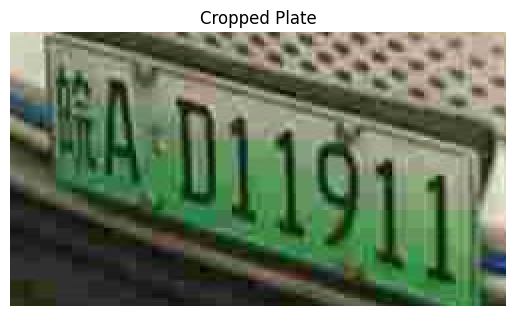

------------------------------
🔍 深度诊断信息
原始索引序列: [ 1  0  1  3  1  1  1  1  2  1 16  0  0  1  4  0  0  0  1  0  1  1  1  1
  1  1  1  1  1  0  1  7  9  0  9  9  9 12 16 11 11  2 11  7  5  0 15 11
  7  9  2 14 17  1  4  1  1 11 17  4  1  4  1  1  1  8]
原始字符序列: ['沪', '京', '沪', '渝', '沪', '沪', '沪', '沪', '津', '沪', '豫', '京', '京', '沪', '冀', '京', '京', '京', '沪', '京', '沪', '沪', '沪', '沪', '沪', '沪', '沪', '沪', '沪', '京', '沪', '辽', '黑', '京', '黑', '黑', '黑', '皖', '豫', '浙', '浙', '津', '浙', '辽', '晋', '京', '鲁', '浙', '辽', '黑', '津', '赣', '鄂', '沪', '冀', '沪', '沪', '浙', '鄂', '冀', '沪', '冀', '沪', '沪', '沪', '吉']
最终解码结果: 沪京沪渝沪津沪豫京沪冀京沪京沪京沪辽黑京黑皖豫浙津浙辽晋京鲁浙辽黑津赣鄂沪冀沪浙鄂冀沪冀沪吉
------------------------------
🎉 识别结果: 皖AD1193


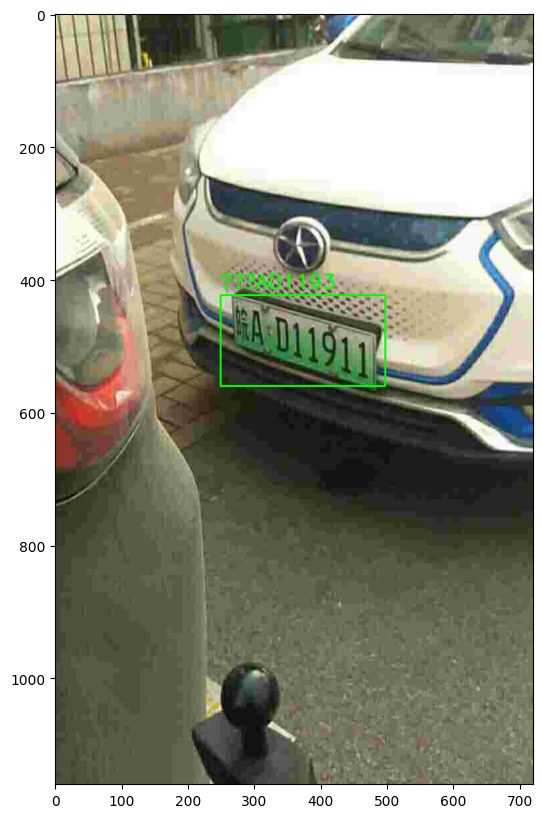

In [ ]:
import cv2
import numpy as np
import onnxruntime
import matplotlib.pyplot as plt
import os

# ================= 配置区域 =================
# 1. 确保路径指向你刚刚验证过的那个 "fixed" YOLOX
yolox_path = "/content/yolox_plate_py38_op11_fixed.onnx"
# 2. 确保指向你自己训练的那个 Opset 11 LPRNet
lprnet_path = "/content/my_lprnet128_op11.onnx"
# 3. 测试图片
image_path = "/content/car.jpg"

# LPRNet 字符表 (66个，不含 I, O，和你训练时一致)
CHARS = [
    '京','沪','津','渝','冀','晋','蒙','辽','吉','黑',
    '苏','浙','皖','闽','赣','鲁','豫','鄂','湘','粤',
    '桂','琼','川','贵','云','藏','陕','甘','青','宁',
    '新',
    '0','1','2','3','4','5','6','7','8','9',
    'A','B','C','D','E','F','G','H','J','K',
    'L','M','N','P','Q','R','S','T','U','V',
    'W','X','Y','Z',
    '-'
]

def decode_lpr(preds):
    # 贪婪解码
    res = []
    for i in range(len(preds)):
        idx = preds[i]
        if idx == len(CHARS) - 1: continue # 跳过空白
        if i > 0 and idx == preds[i-1]: continue # 跳过重复
        res.append(CHARS[idx])
    return "".join(res)

def preprocess_yolox(img, input_size=(640, 640)):
    padded_img = np.ones((input_size[0], input_size[1], 3), dtype=np.uint8) * 114
    r = min(input_size[0] / img.shape[0], input_size[1] / img.shape[1])
    resized_img = cv2.resize(
        img, (int(img.shape[1] * r), int(img.shape[0] * r)), interpolation=cv2.INTER_LINEAR
    ).astype(np.uint8)
    padded_img[: int(img.shape[0] * r), : int(img.shape[1] * r)] = resized_img

    # HWC -> CHW, float32, 不归一化
    blob = padded_img.transpose(2, 0, 1).astype(np.float32)
    blob = blob[None, :, :, :]
    return blob, r

def nms(boxes, scores, nms_thr):
    x1, y1, x2, y2 = boxes.T
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]
    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])
        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)
        inds = np.where(ovr <= nms_thr)[0]
        order = order[inds + 1]
    return keep

# ================= 主程序 =================
if not os.path.exists(yolox_path) or not os.path.exists(lprnet_path):
    print("❌ 错误：找不到 ONNX 模型文件！")
else:
    session_yolo = onnxruntime.InferenceSession(yolox_path)
    session_lpr = onnxruntime.InferenceSession(lprnet_path)

    img_raw = cv2.imread(image_path)
    if img_raw is None:
        print("❌ 读不到图片")
    else:
        # --- YOLOX ---
        input_shape = (640, 640)
        img_in, ratio = preprocess_yolox(img_raw, input_shape)

        # 推理
        out = session_yolo.run(None, {session_yolo.get_inputs()[0].name: img_in})[0]

        # ⚠️⚠️⚠️【关键修正】⚠️⚠️⚠️
        # 你的模型已经解码了 (cx, cy, w, h, obj, cls)，千万不要再跑 demo_postprocess！
        # 直接拿来用！
        predictions = out[0] # [8400, 6]

        # 将 cx,cy,w,h 转为 x1,y1,x2,y2
        boxes_xywh = predictions[:, :4]
        boxes_xyxy = np.ones_like(boxes_xywh)
        boxes_xyxy[:, 0] = boxes_xywh[:, 0] - boxes_xywh[:, 2]/2.
        boxes_xyxy[:, 1] = boxes_xywh[:, 1] - boxes_xywh[:, 3]/2.
        boxes_xyxy[:, 2] = boxes_xywh[:, 0] + boxes_xywh[:, 2]/2.
        boxes_xyxy[:, 3] = boxes_xywh[:, 1] + boxes_xywh[:, 3]/2.

        scores = predictions[:, 4] * predictions[:, 5] # obj * cls

        # 筛选
        mask = scores > 0.5
        boxes = boxes_xyxy[mask]
        scores = scores[mask]

        if len(boxes) == 0:
            print("😱 没检测到车牌")
        else:
            keep = nms(boxes, scores, 0.45)
            final_boxes = boxes[keep]

            for box in final_boxes:
                # 还原到原图
                box /= ratio
                x1, y1, x2, y2 = box.astype(int)

                print(f"📍 车牌坐标: {x1},{y1},{x2},{y2}")

                # Padding

                w = x2 - x1
                h = y2 - y1
                #pad_w = np.clip(w * 0.08, 5, 40)
                #pad_h = np.clip(h * 0.08, 5, 40)

                #x1 = int(x1 - pad_w)
                #y1 = int(y1 - pad_h)
                #x2 = int(x2 + pad_w)
                #y2 = int(y2 + pad_h)
                pad_w, pad_h = int(w*0.05), int(h*0.05)
                x1 = max(0, x1-pad_w)
                y1 = max(0, y1-pad_h)
                x2 = min(img_raw.shape[1], x2+pad_w)
                y2 = min(img_raw.shape[0], y2+pad_h)

                # 抠图
                plate_img = img_raw[y1:y2, x1:x2]

                # 展示抠图 (确认这次对了)
                plt.imshow(cv2.cvtColor(plate_img, cv2.COLOR_BGR2RGB))
                plt.title("Cropped Plate")
                plt.axis('off')
                plt.show()

                # --- LPRNet ---
                # 1. 保持彩色！不要转灰度！
                # 2. 预处理
                lpr_img = cv2.resize(plate_img, (128, 24), interpolation=cv2.INTER_CUBIC) # 推荐用 CUBIC

                lpr_img = lpr_img.astype('float32')
                lpr_img -= 127.5
                lpr_img *= 0.0078125
                lpr_img = lpr_img.transpose(2, 0, 1) # HWC->CHW
                lpr_img = lpr_img[None, ...]         # Add batch

                # 推理
                # ... 推理得到 lpr_out ...
                # lpr_out shape: [1, 18, 66]

                # 1. 获取每一时间步的最大概率索引
                raw_preds = np.argmax(lpr_out[0], axis=1) # [18] (假设是这个维度，跟之前一样)

                # 2. 打印原始序列 (不要解码，直接看原始输出)
                print("-" * 30)
                print("🔍 深度诊断信息")
                print(f"原始索引序列: {raw_preds}")

                # 翻译成字符看看 (不去重)
                raw_chars = [CHARS[idx] for idx in raw_preds]
                print(f"原始字符序列: {raw_chars}")

                # 3. 你的解码结果
                decoded_text = decode_lpr(raw_preds)
                print(f"最终解码结果: {decoded_text}")
                print("-" * 30)

                # 解码
                # lpr_out shape: [1, 18, 66] (T, N, C) after squeeze/permute in training
                # 但转ONNX后通常变成 [1, 66, 18] 或 [1, 18, 66]
                # 根据你训练代码里的 permute(2,0,1)，输出应该是 [18, 1, 66] 或者类似的
                # 我们动态判断一下
                if lpr_out.shape[1] == 66: # [1, 66, 18]
                    preds = np.argmax(lpr_out, axis=1)
                else: # [1, 18, 66]
                    preds = np.argmax(lpr_out, axis=2)

                text = decode_lpr(preds.flatten())
                print(f"🎉 识别结果: {text}")

                cv2.rectangle(img_raw, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(img_raw, text, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)

        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB))
        plt.show()

🚀 加载模型中...
🎉 检测到 1 个车牌


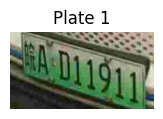

✅ 识别结果: 【 皖AD13953 】


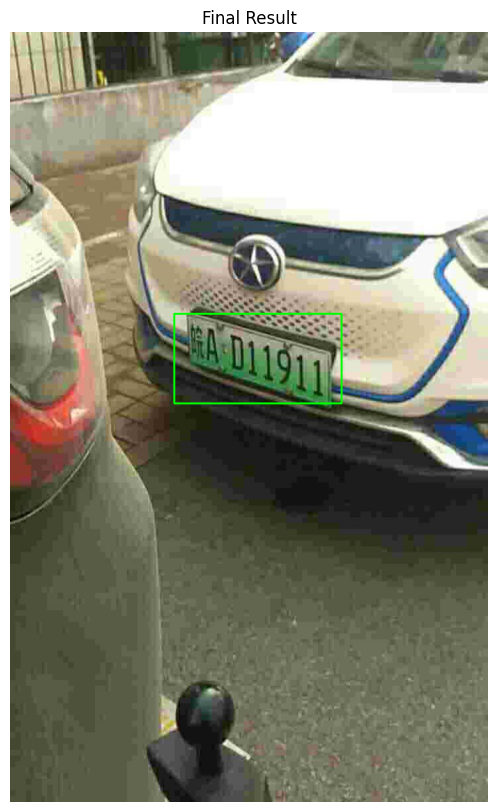

In [10]:
import cv2
import numpy as np
import onnxruntime
import matplotlib.pyplot as plt
import os

# ================= 1. 配置区域 (请确认文件名无误) =================
# YOLOX: 之前用校验脚本导出的，不会全屏框的那个
yolox_path = "/content/yolox_plate_py38_op11_fixed.onnx"

# LPRNet: 刚刚重新训练(128宽)并导出的那个
lprnet_path = "/content/my_lprnet160_op11_fix.onnx"

# 测试图片
image_path = "/content/car.jpg"

# ================= 2. 字典定义 (66类) =================
CHARS_66 = [
    '京','沪','津','渝','冀','晋','蒙','辽','吉','黑',
    '苏','浙','皖','闽','赣','鲁','豫','鄂','湘','粤',
    '桂','琼','川','贵','云','藏','陕','甘','青','宁',
    '新',
    '0','1','2','3','4','5','6','7','8','9',
    'A','B','C','D','E','F','G','H','J','K',
    'L','M','N','P','Q','R','S','T','U','V',
    'W','X','Y','Z',
    '-'
]

# ================= 3. 工具函数 =================
def preprocess_lpr_robust(img_crop):
    # 目标尺寸
    target_w, target_h = 128, 24

    # 1. 计算缩放比例 (保持长宽比)
    h, w = img_crop.shape[:2]
    ratio = min(target_w / w, target_h / h)

    new_w = int(w * ratio)
    new_h = int(h * ratio)

    # 2. 缩放 (改回 LINEAR，和训练保持一致)
    resized = cv2.resize(img_crop, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    # 3. 创建全黑画布
    canvas = np.zeros((target_h, target_w, 3), dtype=np.uint8)

    # 4. 居中粘贴
    # 计算偏移量，让车牌居中
    x_offset = (target_w - new_w) // 2
    y_offset = (target_h - new_h) // 2

    canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized

    # 5. 归一化 (这一步必须严格一致)
    img_in = canvas.astype('float32')
    img_in -= 127.5
    img_in *= 0.0078125
    img_in = np.transpose(img_in, (2, 0, 1)) # HWC -> CHW
    img_in = img_in[None, ...] # Add Batch

    return img_in
def preprocess_yolox(img, input_size=(640, 640)):
    padded_img = np.ones((input_size[0], input_size[1], 3), dtype=np.uint8) * 114
    r = min(input_size[0] / img.shape[0], input_size[1] / img.shape[1])
    resized_img = cv2.resize(
        img, (int(img.shape[1] * r), int(img.shape[0] * r)), interpolation=cv2.INTER_LINEAR
    ).astype(np.uint8)
    padded_img[: int(img.shape[0] * r), : int(img.shape[1] * r)] = resized_img

    # HWC -> CHW, float32, 不归一化
    blob = padded_img.transpose(2, 0, 1).astype(np.float32)
    blob = blob[None, :, :, :]
    return blob, r

def nms(boxes, scores, nms_thr):
    x1, y1, x2, y2 = boxes.T
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]
    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])
        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)
        inds = np.where(ovr <= nms_thr)[0]
        order = order[inds + 1]
    return keep

# ================= 4. 主程序 =================
if not os.path.exists(yolox_path) or not os.path.exists(lprnet_path):
    print("❌ 错误：找不到模型文件，请检查路径！")
else:
    print("🚀 加载模型中...")
    session_yolo = onnxruntime.InferenceSession(yolox_path)
    session_lpr = onnxruntime.InferenceSession(lprnet_path)

    img_raw = cv2.imread(image_path)
    if img_raw is None:
        print("❌ 读不到图片")
    else:
        # --- 步骤 A: YOLOX 检测 ---
        input_shape = (640, 640)
        img_in, ratio = preprocess_yolox(img_raw, input_shape)

        # 推理
        out = session_yolo.run(None, {session_yolo.get_inputs()[0].name: img_in})[0]

        # 因为用的是 fixed 模型，不需要 demo_postprocess，直接取结果
        predictions = out[0]

        # 还原坐标 (cx,cy,w,h -> x1,y1,x2,y2)
        boxes_xywh = predictions[:, :4]
        boxes_xyxy = np.ones_like(boxes_xywh)
        boxes_xyxy[:, 0] = boxes_xywh[:, 0] - boxes_xywh[:, 2]/2.
        boxes_xyxy[:, 1] = boxes_xywh[:, 1] - boxes_xywh[:, 3]/2.
        boxes_xyxy[:, 2] = boxes_xywh[:, 0] + boxes_xywh[:, 2]/2.
        boxes_xyxy[:, 3] = boxes_xywh[:, 1] + boxes_xywh[:, 3]/2.

        scores = predictions[:, 4] * predictions[:, 5]

        # 筛选
        mask = scores > 0.7
        boxes = boxes_xyxy[mask]
        scores = scores[mask]

        if len(boxes) == 0:
            print("😱 没检测到车牌")
        else:
            keep = nms(boxes, scores, 0.45)
            final_boxes = boxes[keep]
            print(f"🎉 检测到 {len(final_boxes)} 个车牌")

            for i, box in enumerate(final_boxes):
                # 坐标还原到原图
                box /= ratio
                x1, y1, x2, y2 = box.astype(int)

                # Padding (稍微扩一点，防止切断字符)
                w, h = x2-x1, y2-y1
                pad_w, pad_h = int(w*0.06), int(h*0.04)
                #pad_w = np.clip(w * 0.08, 5, 40)
                #pad_h = np.clip(h * 0.08, 5, 40)
                #x1 = int(x1 - pad_w)
                #y1 = int(y1 - pad_h)
                #x2 = int(x2 + pad_w)
                #y2 = int(y2 + pad_h)
                x1 = max(0, x1-pad_w)
                y1 = max(0, y1-pad_h)
                x2 = min(img_raw.shape[1], x2+pad_w)
                y2 = min(img_raw.shape[0], y2+pad_h)

                # 抠图
                plate_img = img_raw[y1:y2, x1:x2]

                # 展示抠图
                plt.figure(figsize=(3,1))
                plt.imshow(cv2.cvtColor(plate_img, cv2.COLOR_BGR2RGB))
                plt.title(f"Plate {i+1}")
                plt.axis('off')
                plt.show()

                # --- 步骤 B: LPRNet 识别 (你的核心逻辑) ---

                # 1. 预处理 (必须是 128x24)
                lpr_img = cv2.resize(plate_img, (160, 24), interpolation=cv2.INTER_CUBIC)

                # 2. 归一化 (这一步绝对不能少！你的截图里注释掉了，如果是 raw pixel 肯定不对)
                lpr_img = lpr_img.astype('float32')
                lpr_img -= 127.5
                lpr_img *= 0.0078125

                # 3. 维度变换
                lpr_img = lpr_img.transpose(2, 0, 1)[None, ...] # HWC -> 1CHW

                # 4. 推理
                lpr_out = session_lpr.run(None, {session_lpr.get_inputs()[0].name: lpr_img})[0]


                # 3. 维度判断解码
                output_tensor = lpr_out[0]
                class_dim = -1
                if output_tensor.shape[0] in [66, 68]: class_dim = 0
                elif output_tensor.shape[1] in [66, 68]: class_dim = 1

                if class_dim == -1: raw_preds = np.argmax(output_tensor, axis=0) # 盲猜
                else: raw_preds = np.argmax(output_tensor, axis=class_dim)

                # 4. 解码字符串
                res_text = ""
                last_char = ""
                for idx in raw_preds:
                    if idx >= len(CHARS_66): continue
                    char = CHARS_66[idx]
                    if char == '-':
                        last_char = '-'
                        continue
                    if char != last_char:
                        res_text += char
                        last_char = char

                print(f"✅ 识别结果: 【 {res_text} 】")

                # 画框写字
                cv2.rectangle(img_raw, (x1, y1), (x2, y2), (0, 255, 0), 2)
                # cv2.putText 不支持中文，这里只画框，或者你可以把 res_text 换成拼音显示
                # cv2.putText(img_raw, res_text, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)

        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB))
        plt.title("Final Result")
        plt.axis('off')
        plt.show()